In [9]:
import numpy as np
import pandas as pd
pd.set_option('precision', 10)

import scipy.sparse
import pickle
import xgboost as xgb

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 20,10

import mix as mix
import db_column_name as db
from sklearn.metrics import  mean_squared_error


columnName = db.ColumnName()

def modify(df):
    df = df.drop(['min slptend', 'min advRh850', 'min rainc', 
                  'min totalprecip', 'min t2', 'min rainnc'], axis=1)
    df['actual_date'] = pd.to_datetime(df['actual_date'])
    df.set_index('actual_date', inplace=True)
    df = df.sort_index()
    df = df[[x for x in df.columns if 'min' in x or x == columnName.value]]
    return mix.clean_dataset(df)
    
X_train = pd.read_csv('./date/X_train.csv')
X_train = modify(X_train)

X_test = pd.read_csv('./date/X_test.csv')
X_test = modify(X_test)

X_train, target_train = mix.getTarget(X_train)
X_test, target_test = mix.getTarget(X_test)

X_train['prev_value'] = target_train.shift(1)
X_test['prev_value'] = target_test.shift(1)
X_test.iloc[0, -1] = X_train.iloc[-1, -1] 

X_train['month'] = target_train.index.month
X_test['month'] = target_test.index.month

print("Size train {}".format(X_train.shape))
print("Size train {}".format(X_test.shape))

Size train (1043, 50)
Size train (153, 50)


In [10]:
default_params = {
    'verbosity':0,
    'max_depth': 3,
    
#     'learning_rate': 0.09,
    'min_child_weight': 3.0100000000000001,
    'subsample':0.8, 
    'colsample_bytree':0.8,
    'gamma': 9,
}


reg = xgb.XGBRegressor(**default_params)

reg.fit(X_train, target_train[[columnName.value]],
        eval_set=[(X_test, target_test[[columnName.value]])],
        early_stopping_rounds=50)

target_test['XGB prediction'] = reg.predict(X_test, ntree_limit=reg.best_ntree_limit)
target_train['XGB prediction'] = reg.predict(X_train,  ntree_limit=reg.best_ntree_limit)
    
mix.print_mean(target_test, target_train, columnName.value, 'XGB prediction') 

[0]	validation_0-rmse:15.108
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:13.6821
[2]	validation_0-rmse:12.2895
[3]	validation_0-rmse:11.0346
[4]	validation_0-rmse:9.9485
[5]	validation_0-rmse:9.04217
[6]	validation_0-rmse:8.2149
[7]	validation_0-rmse:7.50664
[8]	validation_0-rmse:6.85851
[9]	validation_0-rmse:6.31081
[10]	validation_0-rmse:5.7985
[11]	validation_0-rmse:5.37748
[12]	validation_0-rmse:4.99092
[13]	validation_0-rmse:4.71942
[14]	validation_0-rmse:4.44888
[15]	validation_0-rmse:4.22585
[16]	validation_0-rmse:4.04284
[17]	validation_0-rmse:3.91472
[18]	validation_0-rmse:3.81336
[19]	validation_0-rmse:3.69249
[20]	validation_0-rmse:3.59997
[21]	validation_0-rmse:3.51782
[22]	validation_0-rmse:3.465
[23]	validation_0-rmse:3.41047
[24]	validation_0-rmse:3.36063
[25]	validation_0-rmse:3.30445
[26]	validation_0-rmse:3.30841
[27]	validation_0-rmse:3.27548
[28]	validation_0-rmse:3.25096
[29]	validation_0-rmse:3.24517
[30]	validation_0-rms

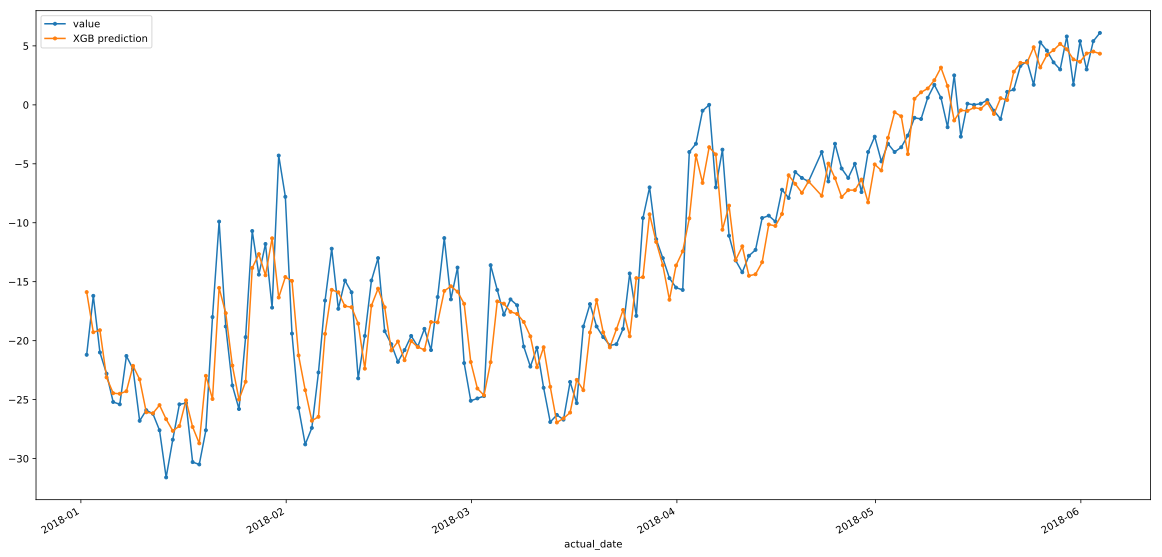

In [57]:

target_test[[columnName.value, 'XGB prediction']].plot(style='.-')

In [478]:
# from sklearn.model_selection import validation_curve
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# param_test1 = {
#     'min_child_weight': np.arange(1, 5, step=0.1)
# }

# xgb_model = xgb.XGBRegressor(**default_params)

# xgb_grid = GridSearchCV(xgb_model, 
#                         param_grid = param_test1, verbose=1,
#                         n_jobs=4, cv=TimeSeriesSplit(n_splits=5))
# xgb_grid.fit(X_train, target_train[[columnName.value]])

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

# target_test['XGB Gride'] = xgb_grid.predict(X_test)
# target_train['XGB Gride'] = xgb_grid.predict(X_train)
# mix.print_mean(target_test, target_train, columnName.value, 'XGB Gride')

In [479]:
# from sklearn.feature_selection import SelectFromModel
# from numpy import sort

# print(reg.feature_importances_)

# selection = SelectFromModel(reg, threshold=0.0051, prefit=True)
# # n_features = selection.transform(X_train).shape[1]
# # while n_features > 15:
# #     selection.threshold += 0.001
# #     X_transform = selection.transform(X_train)
# #     n_features = X_transform.shape[1]

# select_X_train = selection.transform(X_train)
# print("Features {}".format(select_X_train.shape))
# print("Threshold {}".format(selection.threshold))
# param = {
#     'verbosity':0,
# #     'max_depth': 7,
    
# #     'learning_rate': 0.05,
# #     'min_child_weight': 3,
# #     'gamma': 8.1,
# #     'subsample':0.8, 
# #     'colsample_bytree':0.8,
# }

# selection_model = xgb.XGBRegressor(**params)

# select_X_test = selection.transform(X_test)

# selection_model.fit(select_X_train, target_train[[columnName.value]])

# target_test['XGB select'] = selection_model.predict(select_X_test)
# target_train['XGB select'] = selection_model.predict(select_X_train)

# mix.print_mean(target_test, target_train, columnName.value, 'XGB select')

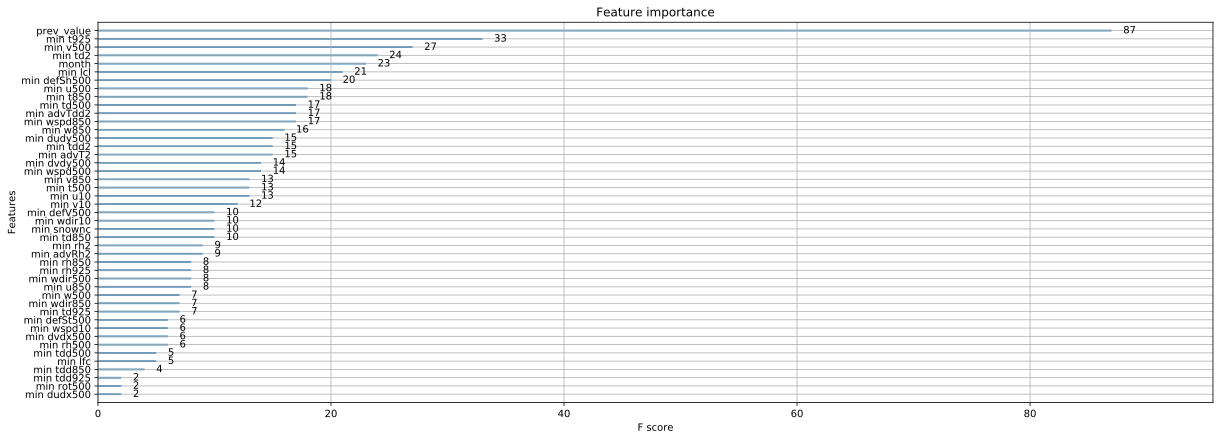

In [11]:
fig, ax = plt.subplots(figsize=(20, 7))
xgb.plot_importance(reg, ax=ax);

In [481]:


# n_estimators_range = np.linspace(0.09, 0.2, num=50)

# train_scores, test_scores = validation_curve(
#     xgb.XGBRegressor(max_depth=3,subsample=0.7,random_state=42,n_estimators=153),
#     X_test, target_test[[columnName.value]],
#     param_name = 'learning_rate',
#     param_range = n_estimators_range,
#     cv=TimeSeriesSplit(n_splits=10))


# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# fig = plt.figure(figsize=(10, 6), dpi=100)

# plt.title("Validation Curve with XGBoost ")
# plt.xlabel("gamma")
# plt.ylabel("Accuracy")
# plt.ylim(0.5, 1.01)

# plt.plot(n_estimators_range,
#              train_scores_mean,
#              label="Training score",
#              color="r")

# plt.plot(n_estimators_range,
#              test_scores_mean, 
#              label="Cross-validation score",
#              color="g")

# plt.fill_between(n_estimators_range, 
#                  train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, 
#                  alpha=0.2, color="r")

# plt.fill_between(n_estimators_range,
#                  test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std,
#                  alpha=0.2, color="g")

# plt.axhline(y=1, color='k', ls='dashed')

# plt.legend(loc="best")
# plt.show()
# i = np.argmax(test_scores_mean)
# print("Best cross-validation result ({:.2f}) obtained for {} n_estimators".format(test_scores_mean[i],n_estimators_range[i]))

In [24]:
import scipy

def fft_(X, target):
    N = target.shape[0]
    y = target[[columnName.value]]
    y.reset_index(drop=True, inplace=True)
    
    Y = np.fft.fft(y.values)
    index = np.fft.fftfreq(N)
    amplit_Y  = np.abs(Y)
    phase_Y = np.angle(Y)

    fft_target = pd.DataFrame(np.hstack((amplit_Y, phase_Y)), columns=['amplitude', 'phase']) 
    fft_target.set_index(index, inplace=True)
    fft_X = X.set_index(index)
    return fft_X, fft_target

fft_X_train, fft_target_train = fft_(X_train, target_train)
fft_X_test, fft_target_test = fft_(X_test, target_test)

fft_X_train['prev_value'] = fft_target_train.sort_index().shift(1)
fft_X_test['prev_value'] = fft_target_test.sort_index().shift(1)
fft_X_test.iloc[0, -1] = fft_X_train.iloc[-1, -1] 
fft_X_train = fft_X_train.drop(['month'], axis=1)
fft_X_test = fft_X_test.drop(['month'], axis=1)

In [45]:
def com(radii, angles):
    return radii * np.around(np.exp(1j*angles), 10)

def complex_(r, a):
    Y_ = np.array(com(r, a).values)
    Y_ = Y_.reshape((Y_.size, 1))
    return Y_

params = {
    'verbosity':0,
    'max_depth': 5,
    
    'learning_rate': 0.05,
    
    
    'min_child_weight': 6,
#     'subsample':0.8, 
#     'colsample_bytree':0.8,
#     'gamma': 12,
}

reg = xgb.XGBRegressor(**params)
reg.fit(fft_X_train, fft_target_train.iloc[:, 0])

fft_target_test['Predict am'] = reg.predict(fft_X_test)
fft_target_train['Predict am'] = reg.predict(fft_X_train)

Y = complex_(fft_target_train.iloc[:, 2], fft_target_train.iloc[:, 1])
target_train['FFT prediction'] = np.fft.ifft(Y).real

Y = complex_(fft_target_test.iloc[:, 2], fft_target_test.iloc[:, 1])
target_test['FFT prediction'] = np.fft.ifft(Y).real

print("T")
mix.print_mean(target_test, target_train, columnName.value, 'FFT prediction')


/usr/lib/python3.7/site-packages/xgboost-0.81-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/lib/python3.7/site-packages/xgboost-0.81-py3.7.egg/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


T
Mean squared error on train 1.7343950708686062 and test 10.093662271688897
Mean absolute error on train 1.0180823168612851 and test 2.3819105045468203
Explained variance score on train 0.9898812903562021 and test 0.9013935227026714
Coefficient of determination on train 0.98986033523108 and test 0.9008002313637322
Median absolute error on train 0.8471744537353523 and test 1.852052307128906
Mean absolute percentage error on train 0.37088994508776707 and test 0.7310084266163456


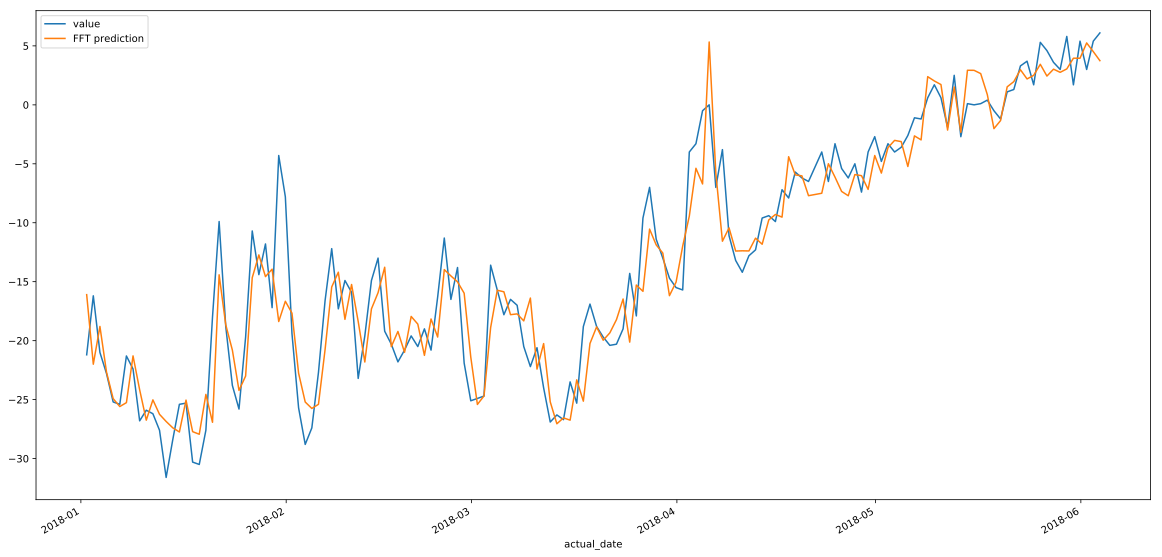

In [531]:

target_test[[columnName.value, 'FFT prediction']].plot()